Tuning dataset with Hyperopt - an automated smart sampler

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier 
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline
df = pd.read_csv('../../csvs/short_integration_features.csv', index_col=0)
del df['instability_time']
del df['Rel_Eerr']
del df['Rel_Eerr_short']
del df["runstring"]
#Nrows = df.shape[0]
#print Nrows, len(np.where(df['Stable']==0)[0])
print df.shape
print df.columns.values
df.head()

(14999, 114)
['Stable' 't_final_short' 'avg_a1' 'std_a1' 'max_a1' 'min_a1' 'norm_std_a1'
 'norm_max_a1' 'norm_std_window10_a1' 'norm_max_window10_a1' 'avg_e1'
 'std_e1' 'max_e1' 'min_e1' 'norm_std_e1' 'norm_max_e1'
 'norm_std_window10_e1' 'norm_max_window10_e1' 'avg_inc1' 'std_inc1'
 'max_inc1' 'min_inc1' 'norm_std_inc1' 'norm_max_inc1'
 'norm_std_window10_inc1' 'norm_max_window10_inc1' 'avg_eH1' 'std_eH1'
 'max_eH1' 'min_eH1' 'avg_iH1' 'std_iH1' 'max_iH1' 'min_iH1' 'avg_ecross1'
 'std_ecross1' 'max_ecross1' 'min_ecross1' 'norm_a1_slope' 'avg_a2'
 'std_a2' 'max_a2' 'min_a2' 'norm_std_a2' 'norm_max_a2'
 'norm_std_window10_a2' 'norm_max_window10_a2' 'avg_e2' 'std_e2' 'max_e2'
 'min_e2' 'norm_std_e2' 'norm_max_e2' 'norm_std_window10_e2'
 'norm_max_window10_e2' 'avg_inc2' 'std_inc2' 'max_inc2' 'min_inc2'
 'norm_std_inc2' 'norm_max_inc2' 'norm_std_window10_inc2'
 'norm_max_window10_inc2' 'avg_eH2' 'std_eH2' 'max_eH2' 'min_eH2' 'avg_iH2'
 'std_iH2' 'max_iH2' 'min_iH2' 'avg_ecross2' 'std_ecro

,Stable,t_final_short,avg_a1,std_a1,max_a1,min_a1,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,...,avg_iH3,std_iH3,max_iH3,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,Lyapunov_time
0,0.0,10000.0,1.000165,0.000329,1.001248,0.999691,0.000329,0.001083,0.000214,0.000456,...,4.706365,0.263380,5.264568,4.410404,0.297364,0.016641,0.339655,0.010871,2.681898e-11,9041.175397
1,0.0,10000.0,0.999952,0.000739,1.002089,0.998309,0.000739,0.002137,0.000202,0.000463,...,1.777638,0.610370,2.507803,0.588028,0.115674,0.039718,0.251880,0.137917,-9.314702e-11,2192.382019
2,0.0,10000.0,0.998498,0.001948,1.002043,0.995446,0.001951,0.003550,0.001735,0.002860,...,0.982187,0.060058,1.060480,0.875622,0.038930,0.002380,0.026117,0.007227,-4.095504e-11,2191.525922
3,1.0,10000.0,1.000006,0.000026,1.000126,0.999973,0.000026,0.000120,0.000005,0.000009,...,9.848375,0.070031,9.914136,9.650551,0.514386,0.003658,0.301072,0.279903,-7.257099e-12,58599.215966
4,0.0,10000.0,1.067267,0.030186,1.121364,1.000000,0.028284,0.063028,0.004313,0.010716,...,1.453843,0.726529,2.660701,0.154157,0.496372,0.248052,1.358604,0.261358,-2.610208e-08,43524.152375


In [3]:
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
#features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
#features += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23'] 
y = df['Stable']
X = df[features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,max_ecross1,min_ecross1,avg_ecross2,std_ecross2,max_ecross2,min_ecross2,avg_ecross3,std_ecross3,max_ecross3,min_ecross3
0,0.396282,0.481704,0.000329,0.001083,0.000214,0.000456,0.000701,0.001978,0.000446,0.000964,...,0.201968,0.011701,0.056614,0.016035,0.333921,0.077775,0.297364,0.016641,0.339655,0.010871
1,1.034575,0.823935,0.000739,0.002137,0.000202,0.000463,0.000200,0.000350,0.000226,0.000377,...,0.529296,0.054017,0.135201,0.071786,0.307149,0.075092,0.115674,0.039718,0.251880,0.137917
2,0.440470,0.491261,0.001951,0.003550,0.001735,0.002860,0.002303,0.004034,0.002080,0.003409,...,0.474815,0.229934,0.141930,0.020783,0.583040,0.328325,0.038930,0.002380,0.026117,0.007227
3,0.432098,0.550624,0.000026,0.000120,0.000005,0.000009,0.000019,0.000050,0.000016,0.000041,...,0.022663,0.000702,0.038023,0.021016,0.048402,0.000124,0.514386,0.003658,0.301072,0.279903
4,5.722053,17.442426,0.028284,0.063028,0.004313,0.010716,0.038832,0.160685,0.090892,0.112168,...,2.500303,0.042790,5.955205,1.404515,9.321252,0.823132,0.496372,0.248052,1.358604,0.261358


In [4]:
Nrows = int(X.shape[0] * 0.8)
trainX = X.iloc[:Nrows,:]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]

Don't worry about number of estimators, learning rate, or colsample_by_tree for now, come back to it afterwards

In [5]:
def objective(space, trainX, trainY):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'])

    xgtrain = DMatrix(trainX.values, label = trainY.values)
    cv_result = xgb.cv(clf.get_params(), xgtrain, num_boost_round = 10, nfold = 5, metrics ='auc', early_stopping_rounds = 5) 

    score = cv_result.iloc[-1]["test-auc-mean"]
    score_std = cv_result.iloc[-1]["test-auc-std"]
    print "SCORE:", score

    return{'loss':1-score, 'status': STATUS_OK, "cv_score":score, "cv_avg":score_std  }

In [6]:
def optimize(trainX, trainY, testX, testY, iterations):
    
    space = {"max_depth": hp.choice('x_max_depth', np.arange(1, 21, dtype=int)),
    'min_child_weight': hp.choice('x_min_child', np.arange(1, 11, dtype=int)),
    'subsample': hp.uniform ('x_subsample', 0.8, 1),
    'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
    'learning_rate': hp.loguniform ('x_learning_rate', -3*np.log(10), -1*np.log(10)),
    #'trainX': trainX, 'trainY':trainY
    }

    trials = Trials()
    optimize_func = partial(objective, trainX= trainX, trainY =trainY)
    best = fmin(fn = optimize_func, space = space, algo= tpe.suggest, max_evals = iterations)
    #this will print out the score at each iteration, can pipe it to a text file to save it for later
    return best

In [7]:
from functools import partial
from xgboost import DMatrix
iterations=10
best = optimize(trainX, trainY, testX, testY, 10)

SCORE: 0.9696248
SCORE: 0.9683116
SCORE: 0.9645572
SCORE: 0.969642
SCORE: 0.9701732
SCORE: 0.9701904
SCORE: 0.9699066
SCORE: 0.9636822
SCORE: 0.9456298
SCORE: 0.9553786


In [8]:
best

{'x_learning_rate': 0.00158945659624887,
 'x_max_depth': 10,
 'x_min_child': 5,
 'x_subsample': 0.8842843039075888,
 'x_tree_colsample': 0.5393796629807249}

In [9]:
#try testing on the holdout set with these parameters
    
test_best = XGBClassifier(seed = 0, min_child_weight=best["x_min_child"],
                         max_depth = best["x_max_depth"],
                         subsample = best["x_subsample"],
                         colsample_bytree = best["x_tree_colsample"],
                         learning_rate = best["x_learning_rate"])
test_best.fit(trainX, trainY)
preds = test_best.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print auc_Score

0.973801138552


In [10]:
test_best.feature_importances_

array([ 0.02653173,  0.02352298,  0.02634938,  0.02589351,  0.02279358,
        0.01859956,  0.05816922,  0.04932531,  0.02844639,  0.02461707,
        0.03838439,  0.03473742,  0.0195113 ,  0.02334063,  0.04321663,
        0.03419037,  0.06983953,  0.03756382,  0.0511488 ,  0.04549599,
        0.08032458,  0.04111962,  0.04576951,  0.04139314,  0.05579869,
        0.03391685], dtype=float32)

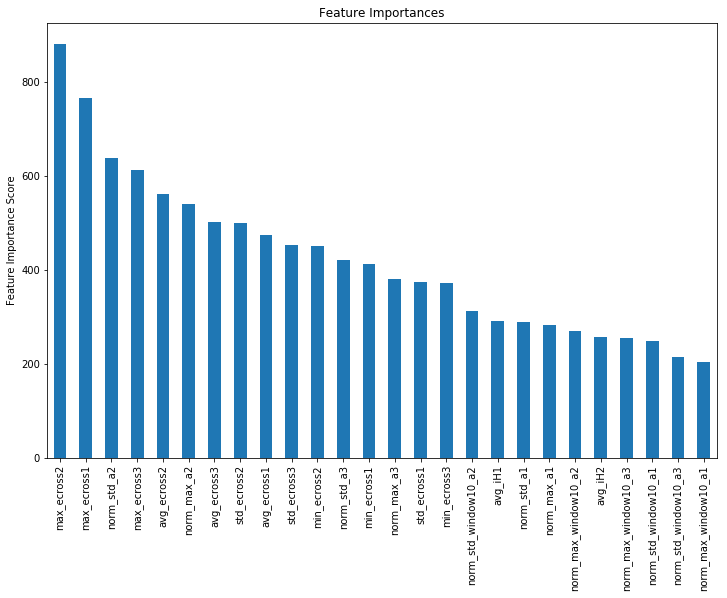

In [11]:
# feature importances
feat_imp = pd.Series(test_best.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()


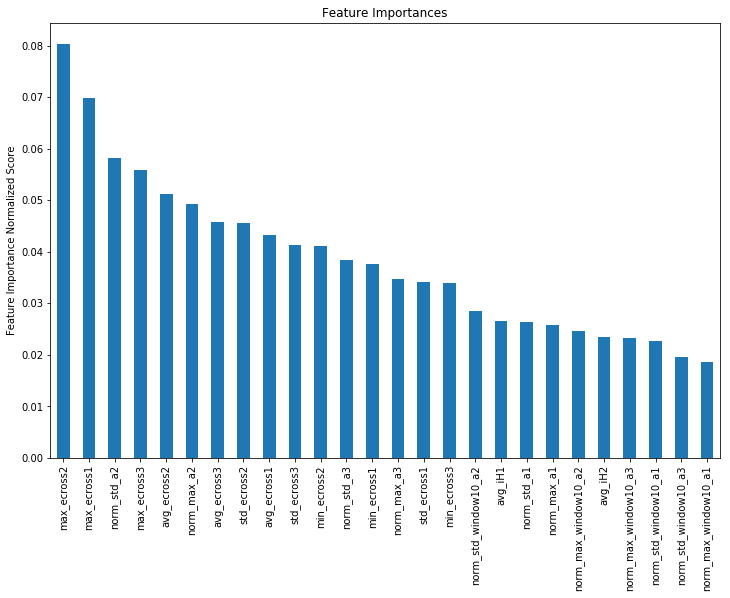

In [12]:
#try drawing a normalized version of the plot
feat_imp_norm = pd.Series(test_best.booster().get_fscore()).sort_values(ascending=False)
feat_imp_norm = feat_imp_norm/np.sum(feat_imp_norm)
#print feat_imp_norm
feat_imp_norm.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Normalized Score')
plt.show()

AUC Score (Test): 0.961897


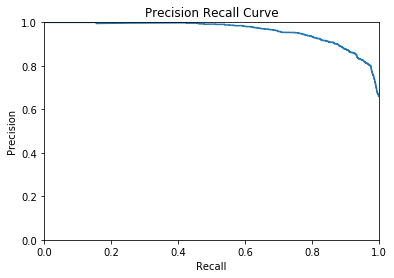

In [13]:
#draw precison recall curve
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
print "AUC Score (Test): %f" % metrics.average_precision_score(testY, preds)
plt.show()


In [14]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 10):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

Threshold 0.434343755245, recall = 1.0, precision = 0.659447753113
Threshold 0.434625774622, recall = 0.999178981938, precision = 0.662493195427
Threshold 0.434917926788, recall = 0.999178981938, precision = 0.666119321292
Threshold 0.43536695838, recall = 0.997536945813, precision = 0.668684645019
Threshold 0.435696870089, recall = 0.99671592775, precision = 0.671831765357
Threshold 0.436116397381, recall = 0.995894909688, precision = 0.675013912076
Threshold 0.436529427767, recall = 0.995073891626, precision = 0.678231673195
Threshold 0.436783134937, recall = 0.994252873563, precision = 0.681485649972
Threshold 0.437644630671, recall = 0.993431855501, precision = 0.684776457272
Threshold 0.438215434551, recall = 0.993431855501, precision = 0.688673875925
Threshold 0.438742905855, recall = 0.993431855501, precision = 0.692615912994
Threshold 0.439166307449, recall = 0.993431855501, precision = 0.69660333909
Threshold 0.439854621887, recall = 0.991789819376, precision = 0.699478865084


[ 0.54972219  0.51495844  0.56290442  0.55089819  0.56931275]
1218 1782
[ 959.  147.   80.   55.   48.   27.   33.   31.   32.   27.   24.   26.
   10.   18.   19.   11.   12.   21.   12.   10.    7.   16.   13.   10.
   11.    7.   10.    7.    7.    6.   10.    9.   10.    6.    6.    2.
    2.   10.    5.    4.    7.    4.    2.    3.    1.    1.    2.    1.
    0.    1.]
[  0   0   3   5   3   2   2   4   4   3   2   3   8  11   6  12   9   5
   5  10  11  10  11  12   6  13  10  16  17   9  17  17  21  17  19  24
  29  24  22  33  35  26  37  34  34  36  50  59  84 198]


(0, 200)

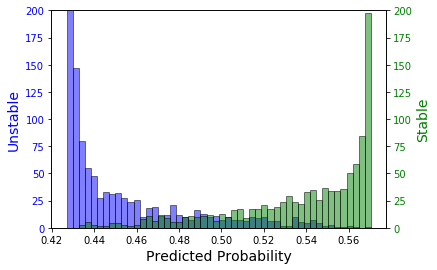

In [15]:
# Histogram:
bins = 50
Stable=preds[np.where(testY==1)]
print Stable[:5][:]
Unstable=preds[np.where(testY==0)]
print Stable.size, Unstable.size


fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
print n
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
print n.astype(int)
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,200]) 
ax2.set_ylim([0,200]) 

In [16]:
def generate_features(sim):
    import pandas as pd
    import numpy as np
    import rebound
    from collections import OrderedDict

    def collision(reb_sim, col):
        reb_sim.contents._status = 5 # causes simulation to stop running and have flag for whether sim stopped due to collision
        return 0

    maxorbs = 1e4    # how many orbits to do
    Nout = 100        # how many output samples
    window = 10       # number of points to take for the 'window' features
    
    ps = sim.particles
    

    P0 = ps[1].P
    tmax = maxorbs * P0 # number of inner planet orbital periods to integrate
    
    sim.collision_resolve = collision

    times = np.linspace(0,tmax,Nout)
    
    a = np.zeros((sim.N,Nout))
    e = np.zeros((sim.N,Nout))
    inc = np.zeros((sim.N,Nout))
    
    beta12 = np.zeros( Nout)
    beta23 = np.zeros(Nout)

    Rhill12 = ps[1].a*((ps[1].m+ps[2].m)/3.)**(1./3.)
    Rhill23 = ps[2].a*((ps[2].m+ps[3].m)/3.)**(1./3.)
    
    eHill = [0, Rhill12/ps[1].a, max(Rhill12, Rhill23)/ps[2].a, Rhill23/ps[3].a]
    daOvera = [0, (ps[2].a-ps[1].a)/ps[1].a, min(ps[3].a-ps[2].a, ps[2].a-ps[1].a)/ps[2].a, (ps[3].a-ps[2].a)/ps[3].a]
    
    for i, t in enumerate(times):
        for j in [1,2,3]:
            a[j,i] = ps[j].a
            e[j,i] = ps[j].e
            inc[j,i] = ps[j].inc

        #need to update rhills?
        Rhill12 = ps[1].a*((ps[1].m+ps[2].m)/3.)**(1./3.)
        Rhill23 = ps[2].a*((ps[2].m+ps[3].m)/3.)**(1./3.)
        
        beta12[i] = (ps[2].a - ps[1].a)/Rhill12
        beta23[i] = (ps[3].a - ps[2].a)/Rhill23   
        sim.integrate(t)
    
    features = OrderedDict()
    
    for string, feature in [("beta12", beta12), ("beta23", beta23)]:
        mean = feature.mean()
        std = feature.std()
        features["avg_"+string] = mean
        features["std_"+string] = std
        features["min_"+string] = min(feature)
        features["max_"+string] = max(feature)

    for j in [1,2,3]:
        for string, feature in [('a', a), ('e', e), ('inc', inc)]:
            mean = feature[j].mean()
            std = feature[j].std()
            features['avg_'+string+str(j)] = mean
            features['std_'+string+str(j)] = std
            features['max_'+string+str(j)] = feature[j].max()
            features['min_'+string+str(j)] = feature[j].min()
            features['norm_std_'+string+str(j)] = std/mean
            features['norm_max_'+string+str(j)] = np.abs(feature[j] - mean).max()/mean
            sample = feature[j][:window]
            samplemean = sample.mean()
            features['norm_std_window'+str(window)+'_'+string+str(j)] = sample.std()/samplemean
            features['norm_max_window'+str(window)+'_'+string+str(j)] = np.abs(sample - samplemean).max()/samplemean

        for string, feature in [('eH', e), ('iH', inc)]:
            mean = feature[j].mean()
            std = feature[j].std()

            features['avg_'+string+str(j)] = mean/eHill[j]
            features['std_'+string+str(j)] = std/eHill[j]
            features['max_'+string+str(j)] = feature[j].max()/eHill[j]
            features['min_'+string+str(j)] = feature[j].min()/eHill[j]

        string, feature = ('ecross', e)
        features['avg_'+string+str(j)] = mean/daOvera[j]
        features['std_'+string+str(j)] = std/daOvera[j]
        features['max_'+string+str(j)] = feature[j].max()/daOvera[j]
        features['min_'+string+str(j)] = feature[j].min()/daOvera[j]

    return pd.DataFrame([pd.Series(features, index=list(features.keys()))])

In [17]:
import rebound
path = '/scratch/dtamayo/'
icpath = path +'random/initial_conditions/runs/ic'
fcpath = path +'random/final_conditions/runs/fc'

testdf = pd.read_csv(path+'random/random.csv', index_col=0)
row = testdf.iloc[0]
sim = rebound.Simulation.from_file(icpath+row['runstring'])

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [18]:
%%time
feat = generate_features(sim)[features]

CPU times: user 299 ms, sys: 11 ms, total: 310 ms
Wall time: 322 ms


In [19]:
test_best.predict(feat)

array([ 0.])

In [20]:
import pickle
pickle.dump([test_best, features, generate_features] ,open("ApplicationsModel.pkl", 'wb'))

In [21]:
import dill

In [22]:
dill.dump([test_best, features, generate_features] ,open("ApplicationsModel.pkl", 'wb'))

In [25]:
df.iloc[Nrows:]

,Stable,t_final_short,avg_a1,std_a1,max_a1,min_a1,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,...,avg_iH3,std_iH3,max_iH3,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,Lyapunov_time
12000,1.0,10000.000000,0.999832,4.925969e-05,1.000011,0.999777,4.926796e-05,0.000179,7.252730e-05,0.000142,...,10.677371,1.100529,12.529792,8.807322,0.563486,0.058079,0.028242,0.026517,-4.392196e-12,11851.260413
12001,0.0,10000.000000,0.997088,5.718964e-04,1.000000,0.996350,5.735665e-04,0.002920,1.062330e-03,0.002098,...,0.717266,0.151539,0.901965,0.379480,0.027482,0.005806,0.087624,0.005501,-3.902511e-12,438534.585885
12002,0.0,10000.000000,1.136361,1.024679e-01,1.449015,0.991621,9.017196e-02,0.275136,6.369101e-03,0.012848,...,2.879218,0.368404,3.447001,2.318421,0.522295,0.066829,0.456050,0.069632,1.224162e-08,11946.836123
12003,0.0,10000.000000,1.006844,6.970658e-03,1.018280,0.995686,6.923272e-03,0.011357,9.317614e-04,0.002204,...,1.133461,0.018141,1.174891,1.106908,0.047148,0.000755,0.069497,0.017796,-1.354529e-09,5715.896431
12004,1.0,10000.000000,1.000036,3.002497e-05,1.000130,0.999990,3.002388e-05,0.000093,3.715660e-05,0.000058,...,3.689782,0.178872,3.953836,3.351671,0.192035,0.009309,0.019557,0.018964,4.022015e-13,6900.683743
12005,0.0,10000.000000,1.000057,4.191222e-04,1.001044,0.999442,4.190981e-04,0.000986,2.171917e-04,0.000340,...,4.672555,0.017588,4.697311,4.633889,0.218251,0.000822,0.039540,0.000430,-3.753754e-11,1704.936409
12006,0.0,2822.229439,0.973121,1.518062e-02,1.008387,0.950477,1.559993e-02,0.036239,5.120029e-03,0.006801,...,1.890861,1.198343,5.038848,0.248903,0.534134,0.338510,3.784497,0.210471,-1.506838e-06,-79941.965938
12007,1.0,10000.000000,1.000004,5.355301e-06,1.000021,0.999996,5.355280e-06,0.000017,3.029024e-06,0.000005,...,3.310185,0.063921,3.374617,3.167342,0.196418,0.003793,0.128123,0.046814,-3.397549e-12,9840.206570
12008,1.0,10000.000000,0.999978,1.298415e-05,1.000017,0.999955,1.298444e-05,0.000039,1.466710e-05,0.000023,...,11.782118,0.162691,12.029199,11.481890,0.550442,0.007601,0.031686,0.028773,-9.703417e-13,29155.076180
12009,1.0,10000.000000,1.000015,1.627258e-05,1.000059,0.999993,1.627233e-05,0.000043,1.552550e-05,0.000037,...,0.261587,0.011971,0.276237,0.238675,0.011608,0.000531,0.048052,0.047612,-6.358693e-13,7006.661637


In [26]:
path = '/scratch/dtamayo/'
icpath = path +'random/initial_conditions/runs/ic'
fcpath = path +'random/final_conditions/runs/fc'

dftesting = pd.read_csv(path+'random/random.csv', index_col=0)

In [95]:
row = dftesting.loc[13000]

In [96]:
sim = rebound.Simulation.from_file(icpath+row['runstring'])
    

In [97]:
feat = generate_features(sim)[features]

In [98]:
feat

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,max_ecross1,min_ecross1,avg_ecross2,std_ecross2,max_ecross2,min_ecross2,avg_ecross3,std_ecross3,max_ecross3,min_ecross3
0,1.099224,0.733603,0.000119,0.00051,0.000044,0.000078,0.000002,0.000007,9.756008e-07,0.000001,...,0.05429,0.010341,0.079553,0.001048,0.028923,0.027287,0.066534,0.027443,0.048872,0.001987


In [99]:
test_best.predict_proba(feat)[0][1]

0.57159466

In [102]:
tester = pd.DataFrame(testX.iloc[1000]).T

In [103]:
tester

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,max_ecross1,min_ecross1,avg_ecross2,std_ecross2,max_ecross2,min_ecross2,avg_ecross3,std_ecross3,max_ecross3,min_ecross3
13000,1.099224,0.733603,0.000119,0.00051,0.000044,0.000078,0.000002,0.000007,9.756008e-07,0.000001,...,0.05429,0.010341,0.079553,0.001048,0.028923,0.027287,0.066534,0.027443,0.048872,0.001987


In [104]:
test_best.predict_proba(tester)[0][1]

0.57159466

In [105]:
len(testX)

3000

In [113]:
%%time
newtestX = []
for i in range(3000):
    try:
        row = dftesting.loc[12000+i]
        sim = rebound.Simulation.from_file(icpath+row['runstring'])
        feat = generate_features(sim)[features]
        newtestX.append(test_best.predict_proba(feat)[0][1])
    except:
        print(i)

CPU times: user 14min 11s, sys: 1.86 s, total: 14min 13s
Wall time: 14min 17s


In [114]:
newtestX

[0.54972219,
 0.42695644,
 0.42695644,
 0.42731261,
 0.51495844,
 0.4693248,
 0.43022585,
 0.56290442,
 0.55089819,
 0.56931275,
 0.48561171,
 0.42695644,
 0.52002233,
 0.54634619,
 0.57068282,
 0.43633598,
 0.56213385,
 0.42695644,
 0.43595701,
 0.47284302,
 0.53601563,
 0.44520086,
 0.42695644,
 0.42695644,
 0.56149876,
 0.56833571,
 0.49286675,
 0.42756921,
 0.42695644,
 0.42718345,
 0.42702433,
 0.42695644,
 0.56877422,
 0.42695644,
 0.46521211,
 0.42695644,
 0.4807775,
 0.42820466,
 0.42755875,
 0.5699507,
 0.42695644,
 0.42695644,
 0.48099816,
 0.56357998,
 0.52727658,
 0.57101095,
 0.48348701,
 0.45500413,
 0.56990802,
 0.43164772,
 0.42851013,
 0.44880304,
 0.42899072,
 0.56210124,
 0.51815152,
 0.56842512,
 0.5652017,
 0.44480327,
 0.47431093,
 0.56944805,
 0.44365579,
 0.42755166,
 0.53776348,
 0.42695644,
 0.42695644,
 0.4917703,
 0.49227533,
 0.51517862,
 0.56745982,
 0.43578923,
 0.57171029,
 0.45311594,
 0.57141298,
 0.45639563,
 0.48743996,
 0.42831311,
 0.42840734,
 0.4

In [112]:
preds = test_best.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print auc_Score

0.973801138552


In [115]:
auc_Score = roc_auc_score(testY,newtestX)
print auc_Score

0.973801138552
